In [1]:
import sys
sys.path.insert(0,'..')

from src.models import *
from src.loss_functions import *
from src.noise import *
from src.metrics import *
from src.plotting import *
from src.generate_data import *
from src.real_data import *
from src.abstain import *

import sklearn
from sklearn.metrics import roc_curve, auc, jaccard_score
import pandas as pd
from supervenn import supervenn

from scipy.stats import bernoulli, spearmanr

from operator import xor

import ast

import os



# Test

In [2]:

def train_model_regret_torch(X_train, yn_train, y_train, X_test, y_test, T,  seed, num_epochs=100, batch_size = 256, correction_type="forward", model_type = "LR"):
    # Check if GPU is available and set the default device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Convert to PyTorch tensors and move them to the device
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train, dtype=torch.long).to(device)
    yn_train = torch.tensor(yn_train, dtype=torch.long).to(device)

    X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test, dtype=torch.long).to(device)

    # Create DataLoader for mini-batch SGD
    train_data = TensorDataset(X_train, yn_train)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    if model_type == "LR":
        # Initialize the model and move it to the device
        model = LogisticRegression(X_train.shape[1]).to(device)
    else:
        # Initialize the model and move it to the device
        model = NeuralNet(X_train.shape[1]).to(device)

    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(model.parameters(), lr=0.01)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    if correction_type in ['backward', 'forward']:

        T = torch.tensor(T).to(device)

    # Train the model
    for epoch in (range(num_epochs)):
        for features, noisy_labels in train_loader:


            # Move features and labels to the device
            features, noisy_labels = features.to(device), noisy_labels.to(device)
            
            # Forward pass
            outputs = model(features)

            if correction_type == 'forward':
                noisy_loss = forward_loss(outputs, noisy_labels, T, device)

                #elapsed = timeit.default_timer() - start_time
                #print("Forward ", elapsed)

            elif correction_type == 'backward':
                noisy_loss = backward_loss(outputs, noisy_labels, T, device)

                #elapsed = timeit.default_timer() - start_time
                #print("Backward ", elapsed)

            else:
                noisy_loss = criterion(outputs, noisy_labels)
                
                #elapsed = timeit.default_timer() - start_time
                #print("BCE ", elapsed)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            noisy_loss.backward()
            optimizer.step()
    
    train_outputs = model(X_train)
    test_outputs = model(X_test)

    # Evaluate the model
    with torch.no_grad():
        
        _, train_preds = torch.max(train_outputs.data, 1)
        train_preds = train_preds.cpu().numpy()
        # Move the predictions back to the CPU for sklearn accuracy calculation
        train_probs = torch.softmax(train_outputs, dim=1).cpu().numpy()

        _, test_preds = torch.max(test_outputs.data, 1)
        test_preds = test_preds.cpu().numpy()
        # Move the predictions back to the CPU for sklearn accuracy calculation
        test_probs = torch.softmax(test_outputs, dim=1).cpu().numpy()


    results = (train_preds,
                test_preds,
                train_probs,
                test_probs
                )
    return model, results


def run_procedure(m, max_iter, X_train, yn_train, X_test, y_test, p_y_x_dict, group_train = None, group_test = None, noise_type = "class_independent", model_type = "LR", T = None, epsilon = 0.25, misspecify = False):
    
    typical_count = 0
    preds_test = []
    preds_train = []
    errors_clean_train = []
    errors_test = []
    plausible_probs = []
    
    y_vec = yn_train
    
    for seed in tqdm(range(1, max_iter+1)):
        
        u_vec = infer_u(y_vec, group = group_train, noise_type = noise_type, p_y_x_dict = p_y_x_dict,  T = T , seed=seed)
        
        
        if misspecify or noise_type == "group":
            typical_flag = True
            
        if not typical_flag:
            typical_flag, _ = is_typical(u_vec, p_y_x_dict, group = group_train,  T = T, y_vec = y_vec, noise_type = noise_type, uncertainty_type = "backward", epsilon = epsilon)
        
            
        flipped_labels = flip_labels(y_vec, u_vec)
        
        model,  (train_acc,
                test_acc,
                train_probs,
                test_probs,
                train_loss,
                test_loss,
                train_preds,
                test_preds
                ) = train_model_ours(X_train, flipped_labels, X_test, y_test, seed = 2024, model_type=model_type)
        
        print("plausible labels "+str(seed)+": ", flipped_labels[:10])
        print("plausible preds  "+str(seed)+": ",train_preds[:10])
        print("")
        preds_test.append(test_preds)
        preds_train.append(train_preds)

        error_clean_train = train_preds != flipped_labels
        error_test = test_preds != y_test
       
        unanticipated_mistake = calculate_unanticipated(train_preds, flipped_labels, y_vec)
        
     
        errors_test.append(error_test)
        errors_clean_train.append(error_clean_train)
        #unanticipated_mistakes.append(unanticipated_mistake)

        plausible_probs.append(test_probs)

        typical_count += 1

        if typical_count == m:
            break
            
    predictions_test = np.array(preds_test)
    ambiguity_test = np.mean(errors_test, axis=0)*100

    predictions_train = np.array(preds_train)
    ambiguity_train = np.mean(errors_clean_train, axis=0)*100

   # unanticipated_mistake_val = np.mean(unanticipated_mistakes, axis=0)*100

    plausible_prob = np.mean(plausible_probs, axis = 0)*100
    #print(np.array(plausible_probs).shape)
    #print(np.array(ambiguity_test).shape)
    
    return ambiguity_train, ambiguity_test, plausible_prob
  


In [7]:
import scipy

dataset = "saps"
noise_type = "class_conditional"
batch_size = 1024
n_draws = 1
model_type = "LR"
training_loss = "None"
n_models = 5
max_iter = 1000


X_train, X_test, y_train, y_test, group_train, group_test = load_dataset_splits(dataset, group="age")

y_train = y_train.astype(int)
y_test = y_test.astype(int)

_, T = generate_class_conditional_noise(y_train, 0.4, 0, 0.0)


p_y_x_dict = calculate_prior(y_train, noise_type=noise_type, group = group_train)  # Clean prior

vectors = Vectors()
for training_loss in ["None"]:
    for model_type in ["LR"]:
        print(model_type)
        for draw_id in range(n_draws):
            u_vec = get_u(y_train, T=T, seed=draw_id, noise_type=noise_type)
            yn_train = flip_labels(y_train, u_vec)

            model, (train_preds, test_preds,
                    train_probs, test_probs) = train_model_regret_torch(
                X_train, yn_train, y_train, X_test, y_test, T,
                seed=2024, num_epochs=2, batch_size=batch_size, correction_type=training_loss, model_type=model_type)
            #print(train_probs[:10])
            # True Population Error
            pop_err_true_train, instance_err_true_train = instance_01loss(y_train, train_preds)
            pop_err_true_test, instance_err_true_test = instance_01loss(y_test, test_preds)
            print(pop_err_true_test)
            (ambiguity_train, 
            ambiguity_test,
            unanticipated_mistake_val) = run_procedure(n_models, 
                                                max_iter, 
                                                X_train, 
                                                yn_train, 
                                                X_test, 
                                                y_test, 
                                                p_y_x_dict, 
                                                group_train = None, 
                                                group_test = None, 
                                                noise_type = noise_type, 
                                                model_type = model_type, 
                                                T = T, 
                                                epsilon = 0.1, 
                                                misspecify = "correct")
            print(unanticipated_mistake_val.shape)
            print("ambiguity: ",ambiguity_train[:20])
            print("median ambiguity: ",np.median(ambiguity_train))
            print("mode ambiguity: ",scipy.stats.mode(ambiguity_train) )
            print("mean ambiguity: ",np.mean(ambiguity_train))

LR
0.2380132776001967


  0%|          | 0/1000 [00:00<?, ?it/s]

LR
plausible labels 1:  [1 1 0 1 0 0 0 0 0 0]
plausible preds  1:  [1 1 1 1 1 1 0 1 0 1]

LR
plausible labels 2:  [1 0 0 1 0 0 0 0 0 0]
plausible preds  2:  [1 1 1 1 1 1 0 1 0 1]

LR
plausible labels 3:  [1 0 0 1 1 1 0 0 0 0]
plausible preds  3:  [1 1 1 1 1 1 0 1 0 0]

LR
plausible labels 4:  [1 0 1 1 0 0 1 0 0 0]
plausible preds  4:  [1 1 1 1 1 1 0 1 0 1]

LR
plausible labels 5:  [1 1 0 1 0 0 1 0 0 0]
plausible preds  5:  [1 1 1 1 1 1 0 1 0 1]

(4067,)
ambiguity:  [  0.  60.  80.   0.  80.  80.  40. 100.   0.  80.  80.  20.   0.  40.
  20.   0.  20. 100.  20.  80.]
median ambiguity:  40.0
mode ambiguity:  ModeResult(mode=array([0.]), count=array([5028]))
mean ambiguity:  36.628757607426074


/tmp/ipykernel_5731/824052639.py:59: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print("mode ambiguity: ",scipy.stats.mode(ambiguity_train) )


# Load Results

In [54]:
fixed_class = 0
fixed_noise = 0.0

all_metrics = []

for dataset in tqdm(["cshock_eicu", "cshock_mimic",  "saps", "support", "lungcancer"]):
    for model_type in ["LR", "NN"]:
        for noise_type in ["class_conditional"]:
            for noise_level in [0.05, 0.2, 0.4]:
                for training_loss in ["None", "backward"]:
                    
                    if training_loss == "None":
                        method_lis = ["metadata", "01"]
                    else:
                        method_lis =  ["metadata"] +[training_loss]
                        
                        
                    try:
                        vectors = load_vectors(dataset, model_type, noise_type, noise_level=noise_level, training_loss = training_loss, fixed_noise=fixed_noise, fixed_class= fixed_class)
                    except Exception as e:
                        print(e)
                        continue

                    metrics_calculator = MetricsCalculator(vectors)
    
                    n_draws = len(metrics_calculator.vectors.vectors['metadata'])
                    metrics = metrics_calculator.get_metrics()

                    for draw_id in range(n_draws):

                        metrics_calculator.calculate_metrics(draw_id)

                    
                        groups = ["age", "hiv"] if  (dataset == "saps" or dataset == "saps_imbalanced") else ["age", "sex"]
                    
                        for method in method_lis:
                            
                             #Get all metric names dynamically
                            all_metric_names = sorted(metrics.get_all_metrics(method, draw_id))
                            for metric_name in all_metric_names:

                                value = metrics.get_metric(method, draw_id, metric_name)

                                #if "vector"  in metric_name:
                                #print(value)
                                all_metrics.append({
                                    "dataset": dataset,
                                    "model_type": model_type,
                                    "noise_type": noise_type,
                                    "noise_level": noise_level,
                                    "training_loss": training_loss,
                                    "err_method": method, #ignore err_method column for now
                                    "draw_id": draw_id,
                                    "metric_name": metric_name,
                                    "value": value if metric_name != "jaccard_train" else value
                                })
#                                 

  0%|          | 0/5 [00:00<?, ?it/s]

In [60]:
metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv('all_results_forward.csv', index=False)
metrics_df

,dataset,model_type,noise_type,noise_level,training_loss,err_method,draw_id,metric_name,value
0,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,ambiguity_train_vector,"[0.04, 1.0, 0.23, 0.0, 0.72, 0.0, 0.0, 0.13, 0..."
1,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,coverage_regret_train,0.636758
2,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,jaccard_train,0.044517
3,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,mean_ambiguity,0.259826
4,cshock_eicu,LR,class_conditional,0.05,None,metadata,0,median_ambiguity,0.04
...,...,...,...,...,...,...,...,...,...
14335,lungcancer,NN,class_conditional,0.40,backward,backward,4,risk_age_1,0.267132
14336,lungcancer,NN,class_conditional,0.40,backward,backward,4,risk_class_0,0.30927
14337,lungcancer,NN,class_conditional,0.40,backward,backward,4,risk_class_1,0.306477
14338,lungcancer,NN,class_conditional,0.40,backward,backward,4,risk_sex_0,0.309387


In [56]:
# metrics_df = pd.read_csv('all_results_forward.csv')
# metrics_df['training_loss'] = metrics_df['training_loss'].fillna("None")
# metrics_df

In [57]:
metrics_df.metric_name.unique()

array(['ambiguity_train_vector', 'coverage_regret_train', 'jaccard_train',
       'mean_ambiguity', 'median_ambiguity',
       'susceptibility_vector_noise', 'susceptibility_vector_posterior',
       'susceptible_noise', 'susceptible_posterior', 'unresponsive_noise',
       'unresponsive_posterior', 'unresponsive_vector_noise',
       'unresponsive_vector_posterior', 'actual_regret_fnr_train',
       'actual_regret_fpr_train', 'actual_regret_train',
       'clean_risk_test', 'clean_risk_train', 'delta_pop_err_train',
       'fn_vector', 'fnr_age_0', 'fnr_age_1', 'fnr_class_0',
       'fnr_class_1', 'fnr_sex_0', 'fnr_sex_1', 'fp_vector', 'fpr_age_0',
       'fpr_age_1', 'fpr_class_0', 'fpr_class_1', 'fpr_sex_0',
       'fpr_sex_1', 'noisy_risk_train', 'regret_age_0', 'regret_age_1',
       'regret_class_0', 'regret_class_1', 'regret_sex_0', 'regret_sex_1',
       'regret_vector', 'risk_age_0', 'risk_age_1', 'risk_class_0',
       'risk_class_1', 'risk_sex_0', 'risk_sex_1', 'fnr_hiv_0',


In [58]:
metrics_df[(metrics_df["metric_name"]=="mean_ambiguity") 
           & (metrics_df["dataset"]=="saps")
           & (metrics_df["noise_level"]==0.05)
           #& (metrics_df["training_loss"]=="backward")
           & (metrics_df["training_loss"]!="forward")
          & (metrics_df["draw_id"]==0)]

,dataset,model_type,noise_type,noise_level,training_loss,err_method,draw_id,metric_name,value
5643,saps,LR,class_conditional,0.05,None,metadata,0,mean_ambiguity,0.220352
5878,saps,LR,class_conditional,0.05,backward,metadata,0,mean_ambiguity,0.220352
7053,saps,NN,class_conditional,0.05,None,metadata,0,mean_ambiguity,0.20662
7288,saps,NN,class_conditional,0.05,backward,metadata,0,mean_ambiguity,0.20662


In [59]:
for model in ["LR", "NN"]:
    print("")
    for training_loss in ["None", "backward"]:
        vectors = load_vectors("support", 
                               model, 
                               noise_type, 
                               noise_level=0.05, 
                               training_loss = training_loss, 
                               fixed_noise=0.0, 
                               fixed_class= 0)

        print(vectors.get_vector("metadata", 0, "train_ambiguity")[:10])


[72. 64.  0. 96. 94.  6.  0.  0.  6.  0.]
[72. 64.  0. 96. 94.  6.  0.  0.  6.  0.]

[23. 56.  6. 26. 78.  6.  8.  0.  7. 11.]
[23. 56.  6. 26. 78.  6.  8.  0.  7. 11.]


Plotting for dataset: cshock_eicu


/tmp/ipykernel_9464/314068823.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['value'] = df['value'].apply(convert_to_float)


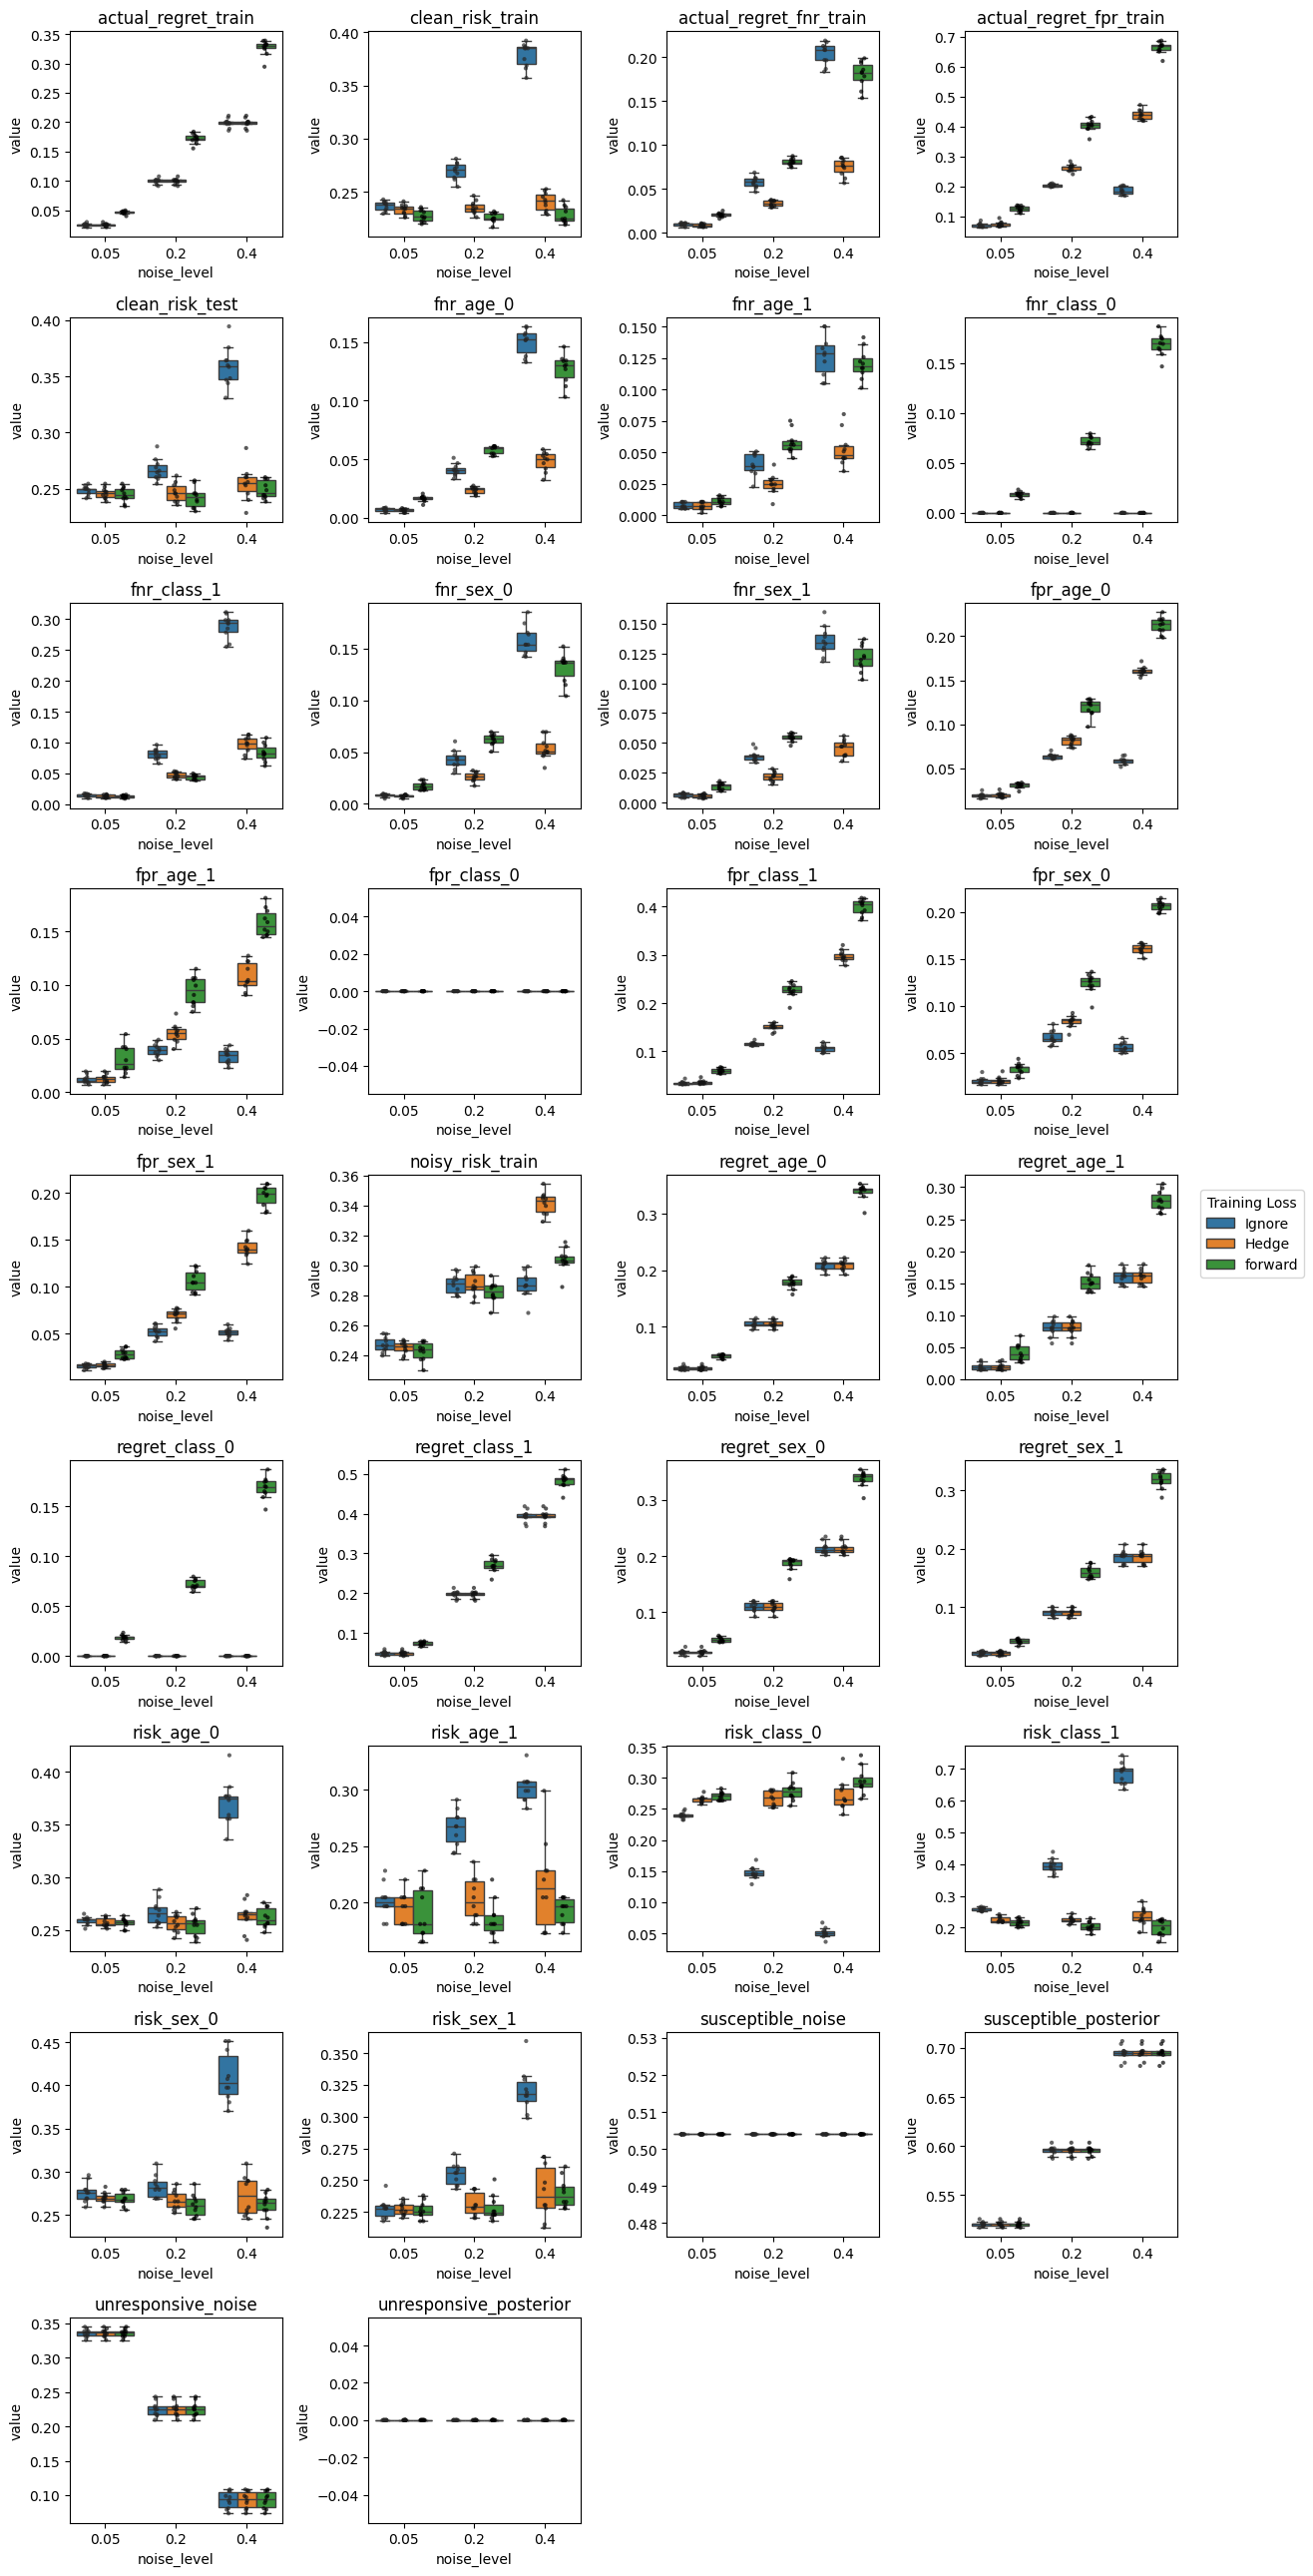

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast

# Function to convert values to float
def convert_to_float(value):
    try:
        if isinstance(value, (int, float)):
            return float(value)
        evaluated_value = ast.literal_eval(value)
        if isinstance(evaluated_value, (list, np.ndarray)):
            return float(evaluated_value[0])
        return float(evaluated_value)
    except (ValueError, SyntaxError, TypeError):
        return np.nan

# Function to create boxplots
def create_boxplot(df, metric_names, title, ncols=4):
    # Convert the 'value' column to float
    df['value'] = df['value'].apply(convert_to_float)

    # Ensure DataFrame is not empty
    if df.empty:
        print("No data available for plotting.")
        return
    
    actual_metric_names = [metric_name for metric_name in metric_names if metric_name in sub_df.metric_name.unique()]
    

    # Set up the number of rows/columns in the plot grid
    nrows = (len(actual_metric_names) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(3 * ncols, 3 * nrows), sharey=False)
    axs = axs.flatten()  # Flatten axes for easier indexing
    
    
    
    for i, metric_name in enumerate(actual_metric_names):
        # Filter data for the current metric
        metric_data = df[df['metric_name'] == metric_name]

        # Ensure there's data for the current metric
        if metric_data.empty:
            continue

        # Plot boxplot
        sns.boxplot(
            ax=axs[i],
            x='noise_level',
            y='value',
            hue='training_loss',
            data=metric_data,
            showfliers=False
        )

        # Overlay stripplot for better visualization of individual points
        sns.stripplot(
            ax=axs[i],
            x='noise_level',
            y='value',
            hue='training_loss',
            data=metric_data,
            dodge=True,
            marker='o',
            s=3,
            alpha=0.7,
            palette='dark:black',
            legend=False  # Avoid multiple legends
        )

        axs[i].set_title(metric_name)
        axs[i].legend().remove()

    # Handle the first plot's legend separately (outside the subplots)
    handles, labels = axs[0].get_legend_handles_labels()
    
    loss_map = {"backward": "Hedge", "None":"Ignore"}
    labels = [loss_map[label] if label in loss_map else label for label in labels]
    fig.legend(handles, labels, title='Training Loss', bbox_to_anchor=(1.05, 0.5), loc='center')

    # Remove unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.savefig(f'/h/snagaraj/noise_multiplicity/figures/appendices_{title}.pdf', dpi=300, bbox_inches='tight')

    plt.show()

# Sample usage
model_type = "LR"
noise_type = "class_conditional"

for dataset in [
    "cshock_eicu",
    "cshock_mimic",
    "support",
    "saps",
    "lungcancer"][:1]:
    sub_df = metrics_df[
        (metrics_df["model_type"] == model_type) & 
        (metrics_df["noise_type"] == noise_type) & 
        (metrics_df["dataset"] == dataset)
    ]

    metric_names = sorted(sub_df['metric_name'].unique())
    metric_names = [name for name in metric_names if '_vector' not in name]
    
    metric_names = ['actual_regret_fnr_train', 
                    'actual_regret_fpr_train', 
                    'actual_regret_train', 
                    'clean_risk_test', 
                    'clean_risk_train', 
                    #'coverage_regret_train', 
                    #'delta_pop_err_train', 
                    'fnr_age_0', 
                    'fnr_age_1', 
                    'fnr_class_0', 
                    'fnr_class_1',
                    'fnr_sex_0', 
                    'fnr_sex_1', 
                    #'fp_vector', 
                    'fpr_age_0', 
                    'fpr_age_1', 
                    'fpr_class_0', 
                    'fpr_class_1',
                    'fpr_sex_0', 
                    'fpr_sex_1', 
                    #'mean_ambiguity', 
                    #'median_ambiguity',
                    'noisy_risk_train', 
                    'regret_age_0', 
                    'regret_age_1', 
                    'regret_class_0', 
                    'regret_class_1', 
                    'regret_sex_0',
                    'regret_sex_1', 
                    #'regret_vector', 
                    'risk_age_0', 
                    'risk_age_1', 
                    'risk_class_0', 
                    'risk_class_1', 
                    'risk_sex_0', 
                    'risk_sex_1',
                    'susceptible_posterior',
                   'susceptible_noise',
                   'unresponsive_posterior',
                   'unresponsive_noise']
    
    priority_metrics = ["actual_regret_train", "clean_risk_train"]
    metric_names = priority_metrics + sorted([name for name in metric_names if name not in priority_metrics])

    print(f"Plotting for dataset: {dataset}")
    create_boxplot(sub_df, metric_names, title = dataset)

In [10]:
sub_df.metric_name.unique()

array(['ambiguity_train_vector', 'coverage_regret_train', 'jaccard_train',
       'mean_ambiguity', 'median_ambiguity',
       'susceptibility_vector_noise', 'susceptibility_vector_posterior',
       'susceptible_noise', 'susceptible_posterior', 'unresponsive_noise',
       'unresponsive_posterior', 'unresponsive_vector_noise',
       'unresponsive_vector_posterior', 'actual_regret_fnr_train',
       'actual_regret_fpr_train', 'actual_regret_train',
       'clean_risk_test', 'clean_risk_train', 'delta_pop_err_train',
       'fn_vector', 'fnr_age_0', 'fnr_age_1', 'fnr_class_0',
       'fnr_class_1', 'fnr_sex_0', 'fnr_sex_1', 'fp_vector', 'fpr_age_0',
       'fpr_age_1', 'fpr_class_0', 'fpr_class_1', 'fpr_sex_0',
       'fpr_sex_1', 'noisy_risk_train', 'regret_age_0', 'regret_age_1',
       'regret_class_0', 'regret_class_1', 'regret_sex_0', 'regret_sex_1',
       'regret_vector', 'risk_age_0', 'risk_age_1', 'risk_class_0',
       'risk_class_1', 'risk_sex_0', 'risk_sex_1'], dtype=object